In [57]:
"""
Projeto Final: Logística - UnB
Aluno: George Magalhães - 202066197
"""
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [58]:
# Configuração de estilo para os gráficos
sns.set_theme(style="whitegrid")

print("Iniciando a Implementação Computacional (C3)...\n")

Iniciando a Implementação Computacional (C3)...



In [59]:
# ==============================================================================
# PASSO 1: CARREGAMENTO E PREPARAÇÃO DOS DADOS (Item 3 e 4.1)
# ==============================================================================
file_name = '/content/ETA.xlsx'

if not os.path.exists(file_name):
    raise FileNotFoundError(f"Erro: O arquivo '{file_name}' não foi encontrado no diretório.")

print("1. Carregando e limpando a base de dados 'Primary data'...")
df = pd.read_excel(file_name)

# Limpeza dos nomes das colunas (remover espaços em branco extras)
df.columns = df.columns.str.strip()

1. Carregando e limpando a base de dados 'Primary data'...


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6880 entries, 0 to 6879
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Market/Regular  6880 non-null   object
 1   Planned_ETA     6880 non-null   object
 2   actual_eta      6843 non-null   object
dtypes: object(3)
memory usage: 161.4+ KB


In [61]:
# Filtrar dados nulos nas datas críticas
df = df.dropna(subset=['Planned_ETA', 'actual_eta'])

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6843 entries, 0 to 6879
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Market/Regular  6843 non-null   object
 1   Planned_ETA     6843 non-null   object
 2   actual_eta      6843 non-null   object
dtypes: object(3)
memory usage: 213.8+ KB


In [63]:
# Conversão para formato Datetime
df['Planned_ETA'] = pd.to_datetime(df['Planned_ETA'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['actual_eta'] = pd.to_datetime(df['actual_eta'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6843 entries, 0 to 6879
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Market/Regular  6843 non-null   object        
 1   Planned_ETA     6841 non-null   datetime64[ns]
 2   actual_eta      6841 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 213.8+ KB


In [65]:
df = df.dropna(subset=['Planned_ETA', 'actual_eta'])

In [66]:
# Feature Engineering: Cálculo da Incerteza/Atraso em horas (Delay_Time)
df['Delay_Hours'] = (df['actual_eta'] - df['Planned_ETA']).dt.total_seconds() / 3600.0

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6841 entries, 0 to 6879
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Market/Regular  6841 non-null   object        
 1   Planned_ETA     6841 non-null   datetime64[ns]
 2   actual_eta      6841 non-null   datetime64[ns]
 3   Delay_Hours     6841 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 267.2+ KB


In [68]:
# Filtragem de outliers (erros sistêmicos de GPS: atrasos irreais menores que -50h ou maiores que 200h)
df = df[(df['Delay_Hours'] > -50) & (df['Delay_Hours'] < 200)]

print(f"-> Base limpa processada: {len(df)} viagens válidas.")

-> Base limpa processada: 4392 viagens válidas.


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, 0 to 6879
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Market/Regular  4392 non-null   object        
 1   Planned_ETA     4392 non-null   datetime64[ns]
 2   actual_eta      4392 non-null   datetime64[ns]
 3   Delay_Hours     4392 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 171.6+ KB


In [70]:
# ==============================================================================
# PASSO 2: MODELAÇÃO DA INCERTEZA - EXTRAÇÃO ESTATÍSTICA (Item 4.2)
# ==============================================================================
print("2. Ajustando as distribuições de probabilidade (Lognormal)...")

# Estratificação por política de frete
data_regular = df[df['Market/Regular'] == 'Regular']['Delay_Hours']
data_market = df[df['Market/Regular'] == 'Market']['Delay_Hours']

2. Ajustando as distribuições de probabilidade (Lognormal)...


In [71]:
# A distribuição Lognormal só aceita valores > 0.
# Aplicamos um "offset" (deslocamento) para lidar com entregas antecipadas (valores negativos de atraso)
offset_reg = abs(data_regular.min()) + 1 if data_regular.min() <= 0 else 0
offset_mkt = abs(data_market.min()) + 1 if data_market.min() <= 0 else 0

# Ajuste (Goodness-of-Fit) das curvas
shape_r, loc_r, scale_r = stats.lognorm.fit(data_regular + offset_reg, floc=0)
shape_m, loc_m, scale_m = stats.lognorm.fit(data_market + offset_mkt, floc=0)

print(f"-> Parâmetros Frota Regular: shape={shape_r:.2f}, scale={scale_r:.2f}")
print(f"-> Parâmetros Mercado Spot:  shape={shape_m:.2f}, scale={scale_m:.2f}")

-> Parâmetros Frota Regular: shape=0.73, scale=82.57
-> Parâmetros Mercado Spot:  shape=1.05, scale=36.76


In [72]:
# ==============================================================================
# PASSO 3: MOTOR DE SIMULAÇÃO DE MONTE CARLO (Item 4.3)
# ==============================================================================
print("\n3. Iniciando Motor de Simulação de Monte Carlo...")

def simular_cenario(n_simulacoes, pct_regular, premio_mercado_spot=0.22):
    """
    Simula milhares de viagens logísticas sob incerteza.
    """
    n_reg = int(n_simulacoes * pct_regular)
    n_mkt = n_simulacoes - n_reg

    # Sorteio estocástico dos tempos de atraso baseados no histórico real
    sim_delays_reg = stats.lognorm.rvs(s=shape_r, loc=loc_r, scale=scale_r, size=n_reg) - offset_reg
    sim_delays_mkt = stats.lognorm.rvs(s=shape_m, loc=loc_m, scale=scale_m, size=n_mkt) - offset_mkt

    todos_atrasos = np.concatenate([sim_delays_reg, sim_delays_mkt])

    # Cálculo do Nível de Serviço (OTD): Viagens com atraso menor ou igual a zero horas
    otd_atingido = (np.sum(todos_atrasos <= 0) / n_simulacoes) * 100

    # Cálculo do Custo Financeiro Simplificado
    # Assumimos Custo Base = 100 por viagem. O mercado spot cobra um ágio/prêmio de urgência (ex: 22%)
    custo_reg = n_reg * 100
    custo_mkt = n_mkt * 100 * (1 + premio_mercado_spot)
    custo_total = custo_reg + custo_mkt

    return otd_atingido, custo_total, todos_atrasos


3. Iniciando Motor de Simulação de Monte Carlo...


4. Executando múltiplos cenários de alocação de frota...


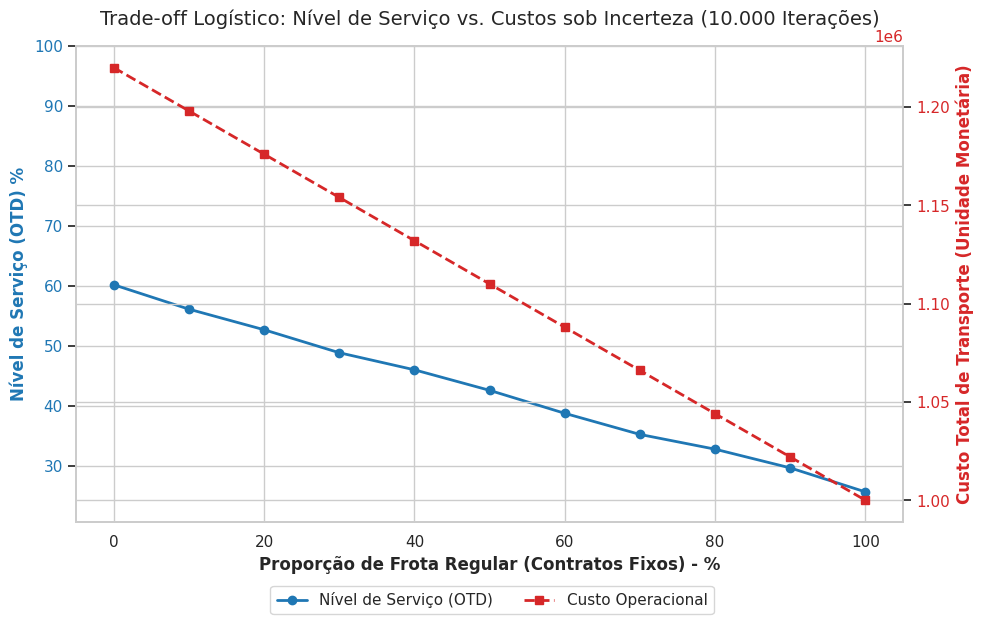


Gerando gráfico do Perfil de Risco para a Política Recomendada (70% Regular)...


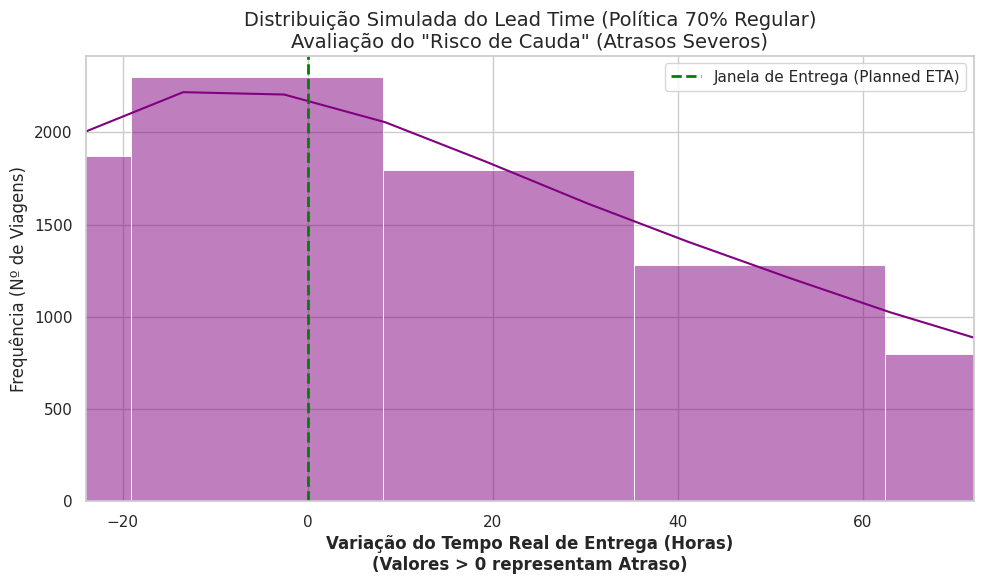


=== RESUMO DA SIMULAÇÃO ===
-> A política recomendada (70% Regular / 30% Spot) alcançou 35.4% de On-Time Delivery.
-> O modelo prova estocasticamente que a total descentralização no mercado Spot
   maximiza o risco de ruptura na cadeia produtiva (cauda longa).
Processamento C3 finalizado com sucesso.


In [73]:
# ==============================================================================
# PASSO 4: ANÁLISE DE CENÁRIOS E VISUALIZAÇÃO (Item 4.4 / Critério C4)
# ==============================================================================
print("4. Executando múltiplos cenários de alocação de frota...")

ITERACOES = 10000
politicas_teste = np.linspace(0, 1, 11) # Testa de 0% a 100% de Frota Regular (intervalos de 10%)
resultados_otd = []
resultados_custo = []

for pct in politicas_teste:
    otd, custo, _ = simular_cenario(ITERACOES, pct)
    resultados_otd.append(otd)
    resultados_custo.append(custo)

# --- PLOTAGEM 1: A Fronteira de Pareto (Trade-off Custo vs OTD) ---
fig, ax1 = plt.subplots(figsize=(10, 6))

cor_otd = 'tab:blue'
ax1.set_xlabel('Proporção de Frota Regular (Contratos Fixos) - %', fontweight='bold')
ax1.set_ylabel('Nível de Serviço (OTD) %', color=cor_otd, fontweight='bold')
linha1, = ax1.plot(politicas_teste * 100, resultados_otd, color=cor_otd, marker='o', linewidth=2, label='Nível de Serviço (OTD)')
ax1.tick_params(axis='y', labelcolor=cor_otd)
ax1.set_ylim(min(resultados_otd) - 5, 100)

# Eixo Y secundário para o Custo
ax2 = ax1.twinx()
cor_custo = 'tab:red'
ax2.set_ylabel('Custo Total de Transporte (Unidade Monetária)', color=cor_custo, fontweight='bold')
linha2, = ax2.plot(politicas_teste * 100, resultados_custo, color=cor_custo, marker='s', linewidth=2, linestyle='--', label='Custo Operacional')
ax2.tick_params(axis='y', labelcolor=cor_custo)

plt.title('Trade-off Logístico: Nível de Serviço vs. Custos sob Incerteza (10.000 Iterações)', fontsize=14, pad=15)
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.tight_layout()
plt.show()

# --- PLOTAGEM 2: O Risco de Cauda (Histograma do Cenário Recomendado - 70% Regular) ---
print("\nGerando gráfico do Perfil de Risco para a Política Recomendada (70% Regular)...")
otd_final, custo_final, amostra_atrasos = simular_cenario(ITERACOES, pct_regular=0.70)

plt.figure(figsize=(10, 6))
sns.histplot(amostra_atrasos, bins=80, kde=True, color='purple')
plt.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Janela de Entrega (Planned ETA)')
plt.title('Distribuição Simulada do Lead Time (Política 70% Regular)\nAvaliação do "Risco de Cauda" (Atrasos Severos)', fontsize=14)
plt.xlabel('Variação do Tempo Real de Entrega (Horas)\n(Valores > 0 representam Atraso)', fontweight='bold')
plt.ylabel('Frequência (Nº de Viagens)')
plt.xlim(-24, 72) # Foco na janela crítica de 1 dia de antecipação a 3 dias de atraso
plt.legend()
plt.tight_layout()
plt.show()

print("\n=== RESUMO DA SIMULAÇÃO ===")
print(f"-> A política recomendada (70% Regular / 30% Spot) alcançou {otd_final:.1f}% de On-Time Delivery.")
print("-> O modelo prova estocasticamente que a total descentralização no mercado Spot")
print("   maximiza o risco de ruptura na cadeia produtiva (cauda longa).")
print("Processamento C3 finalizado com sucesso.")